In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re
import os
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score

from sklearn import svm
from sklearn.svm import LinearSVC

from sklearn.dummy import DummyClassifier


from wordcloud import WordCloud, STOPWORDS

import string
from matplotlib import style

In [2]:
#reading in datasets
clickbait_df=pd.read_csv('clickbait_final.csv',index_col=0)
nytimes_df=pd.read_csv('nytimes_data_final.csv',index_col=0)
guardian_df=pd.read_csv('guardian_headlines.csv',index_col=0)
twp_df=pd.read_csv('TWP_scraped.csv',index_col=0)
reuters_df=pd.read_csv('reuters_100.csv',index_col=0)
bloomberg_df=pd.read_csv('bloomberg_100.csv',index_col=0)

In [3]:
#labeling class to 1 for all clickbait headlines
clickbait_df['class']=1
clickbait_df.shape

(11116, 3)

In [4]:
#labeling 'class' to 0 for non clickbait headlines
nytimes_df['class']=0
nytimes_df.shape

(5299, 3)

In [5]:
guardian_df['class']=0
guardian_df.shape

(3400, 3)

In [6]:
twp_df.rename(columns={'title':"text",'published':'date'},inplace=True)
twp_df['class']=0

In [7]:
reuters_df['class']=0

In [8]:
bloomberg_df['class']=0

In [9]:
all_headlines_df=pd.concat([clickbait_df,nytimes_df,guardian_df,twp_df,reuters_df,bloomberg_df])

In [10]:
all_headlines_df.shape

(20174, 3)

In [11]:
all_headlines_df.drop(columns='date',inplace=True)

In [12]:
dataset2=pd.read_csv('2007_2016_headline_data.csv')

In [13]:
dataset2.rename(columns={'headline':'text','clickbait':'class'},inplace=True)

In [14]:
dataset2

,text,class
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [15]:
df = pd.concat([all_headlines_df,dataset2])

In [16]:
df.shape

(52174, 2)

In [17]:
df['class'].value_counts()

1    27115
0    25059
Name: class, dtype: int64

In [18]:
df.to_csv('total_headlines.csv')

In [19]:
df['class'].value_counts()

1    27115
0    25059
Name: class, dtype: int64

### Process the dataset for EDA and Create additional features

In [20]:
df = pd.read_csv('total_headlines.csv')

In [21]:
#make text lowercase
df['text']=df['text'].apply(lambda x: x.lower())

In [22]:
#function to remove punctuation and non-alphabetical characters and links
import re
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    #text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('“','',text)
    text = re.sub('”','',text)
    text = re.sub('’','',text)
    text = re.sub('–','',text)
    text = re.sub('‘','',text)
    
    return text

In [23]:
#function to find if string contains a question and if so, update new feature with a 1 for yes or 0 for no
question_words = ['who','what','where','why','when','whose','whom','would','will','how','which','should','could']

def contains_question(headline):
    if "?" in headline or headline.startswith(('who','what','where','why','when','whose','whom','would','will','how','which','should','could','did','do')):
        return 1
    else: 
        return 0

df['question_6']=df['text'].apply(contains_question)

In [24]:
df['text'][0].startswith(('who','what','where','why','when','whose','whom','would','will','how','which','should','could','trey'))

True

In [25]:
df.rename(columns={'question_6':'question'},inplace=True)

In [26]:
df['question'].value_counts()

0    47390
1     4784
Name: question, dtype: int64

In [27]:
#create function to find if headline contains '!' and create new feature with 1 for yes and 0 for no
def contains_exclamation(headline):
    if "!" in headline: 
        return 1
    else: 
        return 0
df['exclamation']=df['text'].apply(contains_exclamation)

In [28]:
df.exclamation.value_counts()

0    51616
1      558
Name: exclamation, dtype: int64

In [29]:
#clean headlines to remove puncuation and links
#create feature to count words of each (before removing stop words and numbers)
#create feature to count if headline starts with a digit or not

feature_engineering_clean = lambda x: clean_text_round1(x)
df.text = pd.DataFrame(df.text.apply(feature_engineering_clean))


#create function to find if headline starts with a digit and create new feature with 1 for yes and 0 for no
def starts_with_num(headline):
    if headline.startswith(('1','2','3','4','5','6','7','8','9')): 
        return 1
    else: 
        return 0

df['starts_with_num']=df['text'].apply(starts_with_num)

In [30]:
df.drop(columns='Unnamed: 0',inplace=True)

In [31]:
#create feature that counts words in each headline
df['headline_words'] = df['text'].apply(lambda x: len(x.split()))

In [32]:
df = df[df['headline_words'] != 0]
df

,text,class,question,exclamation,starts_with_num,headline_words
0,trey gowdy just humiliated adam schiff in fron...,1,0,0,0,10
1,60 netflix titles leaving in july 2020,1,0,0,1,7
2,learn how to make a green grape taste like a j...,1,0,1,0,22
3,the new july netflix titles are here and there...,1,0,0,0,13
4,the courts say sex discrimination laws protect...,1,0,0,0,19
...,...,...,...,...,...,...
52169,to make female hearts flutter in iraq throw a ...,0,0,0,0,10
52170,british liberal democrat patsy calton 56 dies ...,0,0,0,0,9
52171,drone smartphone app to help heart attack vict...,0,0,0,0,12
52172,netanyahu urges pope benedict in israel to den...,0,0,0,0,9


In [33]:
df.to_csv('with_engineeredfeat_data.csv')

### EDA

In [34]:
#cleaning data to remove stopwords & tokenize text for EDA

def tokenize(text):
    text = [word_tokenize(x) for x in text]
    return text

df.text = tokenize(df.text)

stopwords_list = stopwords.words('english')
df.text = df['text'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [35]:
#creating seperate dataframes for each class
df_cb=df[df['class']==1]

In [36]:
df_noncb=df[df['class']==0]

In [37]:
#creating a list of unique words for each class
cb_list=list(df_cb['text'])

total_vocab_cb = set()
for word in cb_list:
    total_vocab_cb.update(word)
len(total_vocab_cb)

20291

In [38]:
noncb_list=list(df_noncb['text'])

total_vocab_noncb = set()
for word in noncb_list:
    total_vocab_noncb.update(word)
len(total_vocab_noncb)

23487

In [39]:
flat_cb = [item for sublist in cb_list for item in sublist]
flat_noncb = [item for sublist in noncb_list for item in sublist]


cb_freq = FreqDist(flat_cb)
noncb_freq = FreqDist(flat_noncb)

In [40]:
#top 20 clickbait words 
cb_freq.most_common(20)

[('people', 1745),
 ('things', 1416),
 ('make', 1038),
 ('know', 1005),
 ('new', 947),
 ('like', 809),
 ('17', 785),
 ('best', 733),
 ('actually', 730),
 ('21', 706),
 ('times', 658),
 ('based', 650),
 ('get', 644),
 ('need', 644),
 ('19', 640),
 ('coronavirus', 632),
 ('life', 591),
 ('heres', 586),
 ('one', 585),
 ('trump', 565)]

In [41]:
#top 20 non-clickbait words 
noncb_freq.most_common(20)

[('us', 1483),
 ('new', 1259),
 ('police', 598),
 ('uk', 545),
 ('says', 501),
 ('dies', 492),
 ('coronavirus', 459),
 ('election', 432),
 ('trump', 423),
 ('dead', 404),
 ('first', 381),
 ('killed', 373),
 ('results', 339),
 ('china', 337),
 ('president', 330),
 ('court', 325),
 ('primary', 322),
 ('two', 319),
 ('world', 316),
 ('australian', 308)]

In [42]:
# create counts of clickbait and non-clickbait words and values
cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]

noncb_bar_counts = [x[1] for x in noncb_freq.most_common(20)]
noncb_bar_words = [x[0] for x in noncb_freq.most_common(20)]

plt.style.use('seaborn-talk')

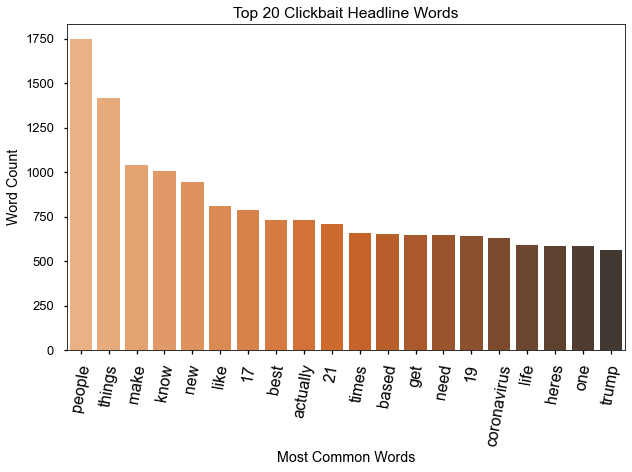

In [43]:
#bar plot for top 15 most common clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(cb_bar_words, cb_bar_counts,palette='Oranges_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style('white')
plt.show()

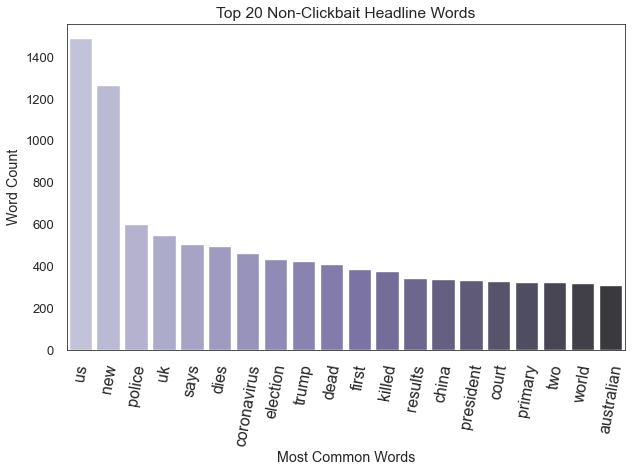

In [44]:
#bar plot for top 15 most common non-clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(noncb_bar_words, noncb_bar_counts,palette='Purples_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Non-Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style()
plt.show()


In [45]:
!pip install wordcloud

You should consider upgrading via the 'c:\anaconda\python.exe -m pip install --upgrade pip' command.


In [46]:
from wordcloud import WordCloud
clickbait_dictionary = dict(zip(cb_bar_words, cb_bar_counts))
nonclickbait_dictionary = dict(zip(noncb_bar_words, noncb_bar_counts))

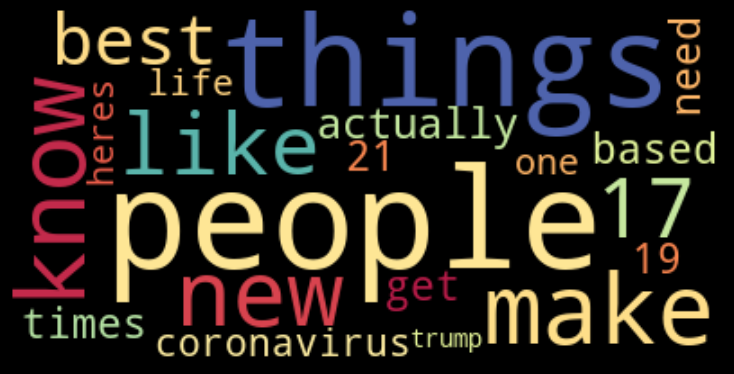

In [47]:
# Create the clickbait word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:

plt.savefig('clickbait_wc')

plt.show()

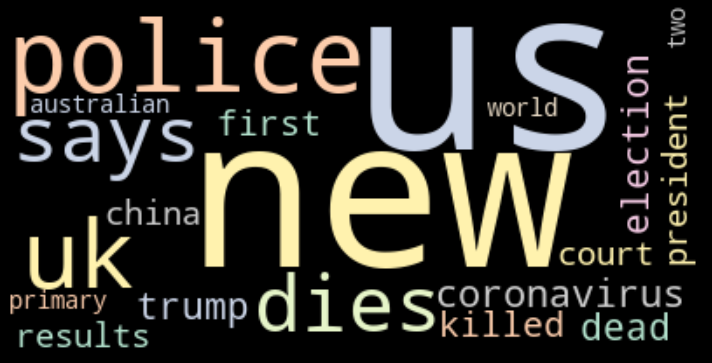

In [48]:
# Create the non-clickbait word cloud:

wordcloud = WordCloud(colormap='Pastel2').generate_from_frequencies(nonclickbait_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
plt.tight_layout()
plt.savefig('clickbait_wc')

plt.show()


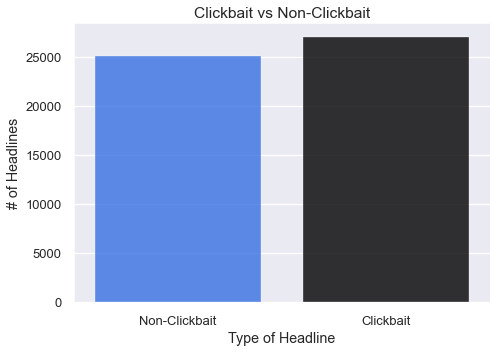

In [49]:
#class variable countplot
#visualizing class frequency of dataset
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
fig1=sns.countplot(df['class'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('Clickbait vs Non-Clickbait')
plt.ylabel('# of Headlines')
plt.xlabel('Type of Headline')
fig1.set(xticklabels=['Non-Clickbait','Clickbait'])
plt.tight_layout()
plt.savefig('class_dist')
plt.show()

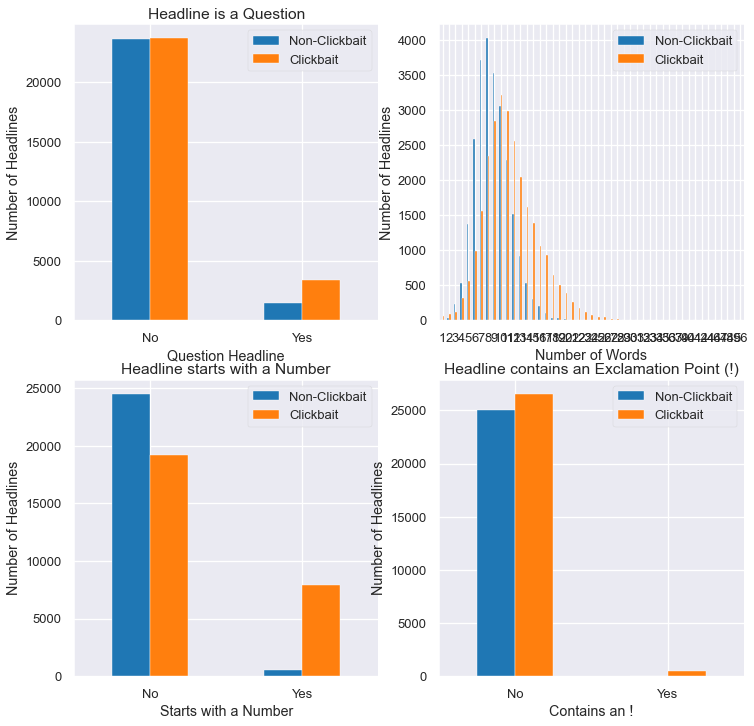

In [50]:
#plotting engineered features to compare by class 
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

plot = df.groupby('question')['class'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_xlabel('Question Headline')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline is a Question')

plot = df.groupby('headline_words')['class'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Number of Words')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])


plot = df.groupby('starts_with_num')['class'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_xlabel('Starts with a Number')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline starts with a Number')

plot = df.groupby('exclamation')['class'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_xlabel('Contains an !')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline contains an Exclamation Point (!)')

style.use('ggplot')
plt.show()

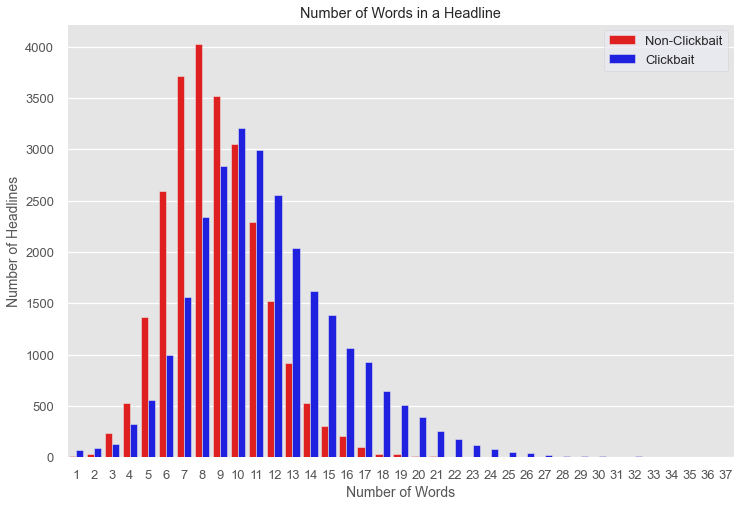

In [51]:
#replotting headline word comparison plot with smaller range

df_words = df[df['headline_words'] < 38]

sns.countplot(df_words['headline_words'],hue=df_words['class'],palette=['red','blue'],data=df_words)
sns.set_style('darkgrid')
plt.xlabel('Number of Words',size=14)
plt.ylabel('Number of Headlines', size=14)
plt.legend(title=None,labels=['Non-Clickbait','Clickbait'],loc='upper right')
plt.title('Number of Words in a Headline')
plt.tight_layout()
plt.savefig('num_words_comparison')

plt.show()

In [52]:
df['class'].value_counts()

1    27070
0    25059
Name: class, dtype: int64

In [53]:
df = pd.read_csv('with_engineeredfeat_data.csv',index_col=0)

In [54]:
df.shape

(52129, 6)

In [55]:
#Create stopwords list
stopwords_list = stopwords.words('english')

features = df.drop(columns='class')
y = df['class']

#classes are mostly balanced
y.value_counts(normalize=True)

1    0.519289
0    0.480711
Name: class, dtype: float64

### Setting up for modeling

- applying TFIDF transformation to headline text
- train/test split
- creating function for results

In [56]:
#first splitting data for test/train sets 
#ngram range -> unigrams and bigrams 

X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=20)

tfidf = TfidfVectorizer(stop_words = stopwords_list,ngram_range = (1,2))
tfidf_text_train = tfidf.fit_transform(X_train['text'])
tfidf_text_test = tfidf.transform(X_test['text'])

X_train_ef = X_train.drop(columns='text')
X_test_ef = X_test.drop(columns='text')

In [57]:
pickle.dump(tfidf,open('tfidf.pkl','wb'))

In [58]:
#combine tf-idf vectors with the engineered features and store as sparse arrays
from scipy import sparse

X_train = sparse.hstack([X_train_ef, tfidf_text_train]).tocsr()
X_test = sparse.hstack([X_test_ef, tfidf_text_test]).tocsr()

In [59]:
X_train_ef

,question,exclamation,starts_with_num,headline_words
28029,0,0,0,11
3376,0,0,0,16
33958,0,0,1,9
48842,0,0,0,10
13386,0,0,0,10
...,...,...,...,...
23497,0,0,1,10
23820,0,0,1,9
37180,0,0,0,5
27143,0,0,1,10


In [60]:
X_test.shape

(13033, 203035)

In [61]:
#creating a function to call after each model iteration to print accuracy and recall scores for test and train
def train_results(preds):
    return "Training Accuracy:", accuracy_score(y_train,preds)," Training Recall:", recall_score(y_train,preds)

def test_results(preds):
    return "Testing Accuracy:", accuracy_score(y_test,preds)," Testing Recall:", recall_score(y_test,preds)

### Dummy Classifier

In [62]:
#baseline model to predict majority class
dc_classifier = DummyClassifier(strategy='most_frequent')

dc_classifier.fit(X_train, y_train)

dc_train_preds = dc_classifier.predict(X_train)
dc_test_preds = dc_classifier.predict(X_test)

print(train_results(dc_train_preds))
print(test_results(dc_test_preds))

('Training Accuracy:', 0.5179813791692245, ' Training Recall:', 1.0)
('Testing Accuracy:', 0.5232103122842017, ' Testing Recall:', 1.0)


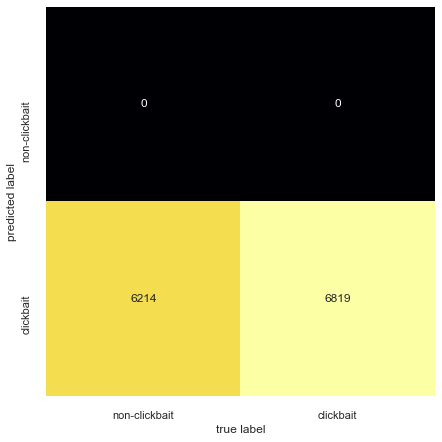

In [63]:
#confusion matrix on test set Dummy Classifier
sns.set()

cm_dc = confusion_matrix(y_test, dc_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### Naive Bayes

In [64]:
nb_classifier = MultinomialNB(alpha = .05)

nb_classifier.fit(X_train, y_train)

nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

print(train_results(nb_train_preds))
print(test_results(nb_test_preds))

('Training Accuracy:', 0.9985676284018825, ' Training Recall:', 0.9989630141721396)
('Testing Accuracy:', 0.9316350801810788, ' Testing Recall:', 0.9403138290071859)


In [65]:
from pickle import dump

dump(nb_classifier,open('nbmodel.pkl','wb'))

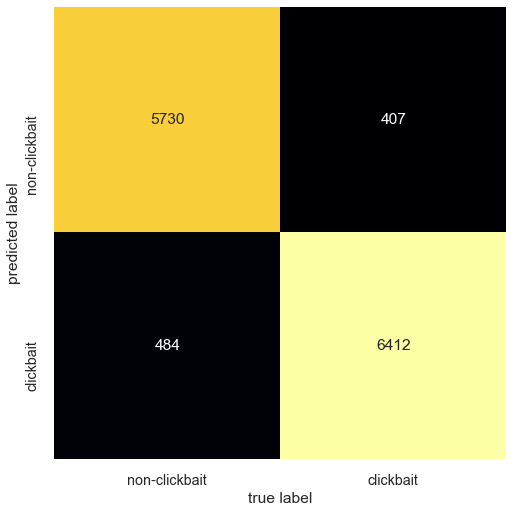

In [66]:
#confusion matrix on test set NB Classifier
sns.set()

cm_dc = confusion_matrix(y_test, nb_test_preds)
sns.set(font_scale=1.3)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.tight_layout()
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('nbcm5')
plt.show();

### Model Interpretations 

In [67]:
#NB coefficients
#creating dataframe for NB coefficients to evaluate the highest/lowest coefficients
coef_nb_2 = pd.DataFrame(nb_classifier.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_nb=coef_nb_2.T

In [68]:
nb_classifier.coef_[0]

array([ -4.86108579,  -6.81409243,  -3.99923789, ..., -15.68208333,
       -15.68208333, -15.68208333])

In [69]:
#creating EF name list
engf_name_list=list(X_train_ef.columns)

In [70]:
engf_name_list

['question', 'exclamation', 'starts_with_num', 'headline_words']

In [71]:
len(tfidf.get_feature_names())

203031

In [72]:
all_feat_names_2 = []

In [73]:
for i in engf_name_list:
    all_feat_names_2.append(i)

In [74]:
for i in tfidf.get_feature_names():
    all_feat_names_2.append(i)

In [75]:
len(all_feat_names_2)

203035

In [76]:
coef_df_nb['tokens']=all_feat_names_2

In [77]:
coef_df_nb.set_index('tokens',inplace=True)
coef_df_nb.columns

Index([0], dtype='object')

In [78]:
coef_df_nb.sort_values(by=0,ascending=False).head(15)

,0
tokens,
headline_words,-0.321767
starts_with_num,-3.999238
question,-4.861086
exclamation,-6.814092
people,-7.564793
things,-7.605109
know,-7.813624
make,-7.925712
actually,-8.053474


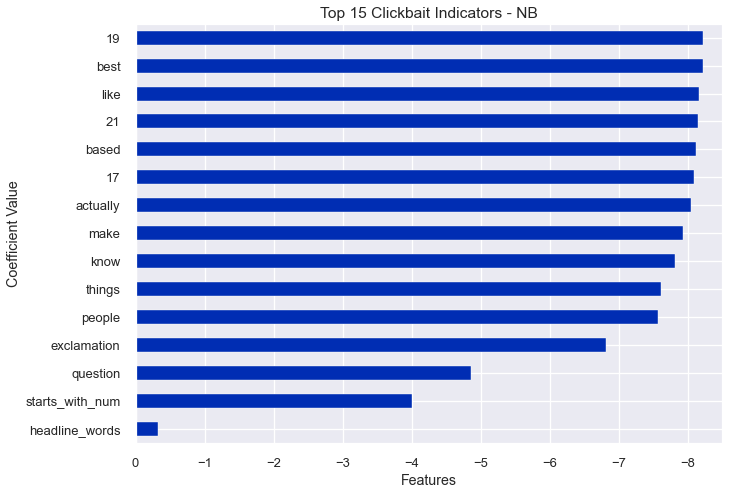

In [79]:
#negative coefficients for non-clickbait
plt.style.use('seaborn-talk')


coef_df_nb[0].sort_values(ascending=False).head(15).plot(kind='barh',color='#002db3')
plt.title("Top 15 Clickbait Indicators - NB")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xlim(0, -8.5)
plt.tight_layout()
plt.savefig('CB_coefs_nb')
plt.show()

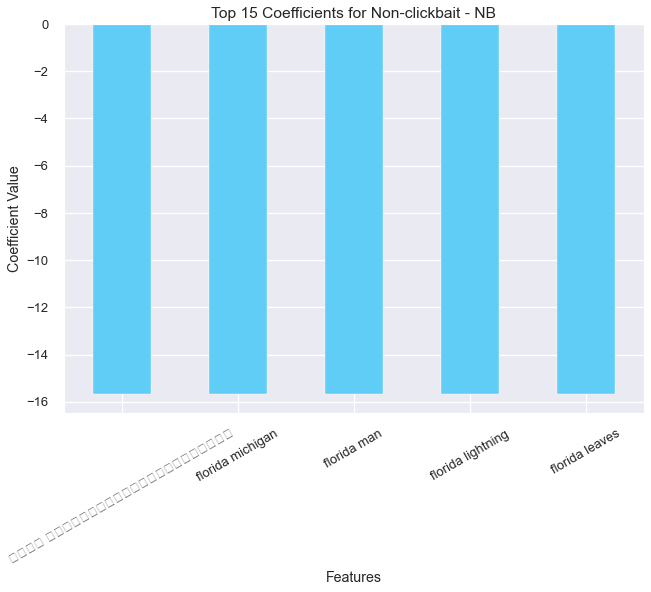

In [80]:
plt.style.use('seaborn-talk')
coef_df_nb[0].sort_values(ascending=True).head().plot(kind='bar',color='#5fcdf5')
plt.title("Top 15 Coefficients for Non-clickbait - NB")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=30)
plt.show()

### SVM

('Training Accuracy:', 0.9998721096787395, ' Training Recall:', 0.9997530986124142)
('Testing Accuracy:', 0.9311747103506484, ' Testing Recall:', 0.9246223786478955)


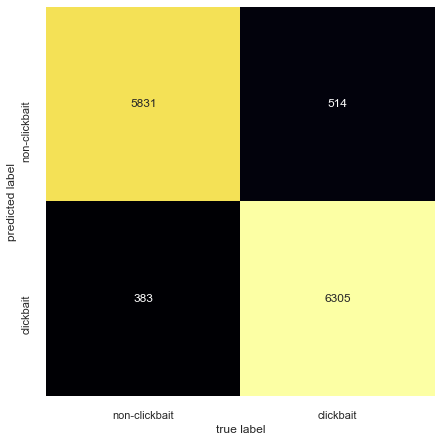

In [81]:
#SVM Model
#svm_classifier = svm.SVC(kernel = 'linear', decision_function_shape='ovo')
svm_classifier = LinearSVC(class_weight='balanced', C=10, max_iter = 1500 )

svm_classifier.fit(X_train, y_train)

svm_test_preds = svm_classifier.predict(X_test)
svm_train_preds = svm_classifier.predict(X_train)

print(train_results(svm_train_preds))
print(test_results(svm_test_preds))

#confusion matrix on test set SVM Classifier 
sns.set()

cm_dc = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

In [82]:
#SVM interpretations 


#svm coefficients
#creating dataframe for SVM coefficients to evaluate the highest coefficients
coef_svm = pd.DataFrame(svm_classifier.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_svm=coef_svm.T

In [83]:
all_feat_names = []

In [84]:
for i in engf_name_list:
    all_feat_names.append(i)

In [85]:
for i in tfidf.get_feature_names():
    all_feat_names.append(i)

In [86]:
len(all_feat_names)

203035

In [87]:
coef_df_svm['tokens']=all_feat_names

In [88]:
coef_df_svm.set_index('tokens',inplace=True)

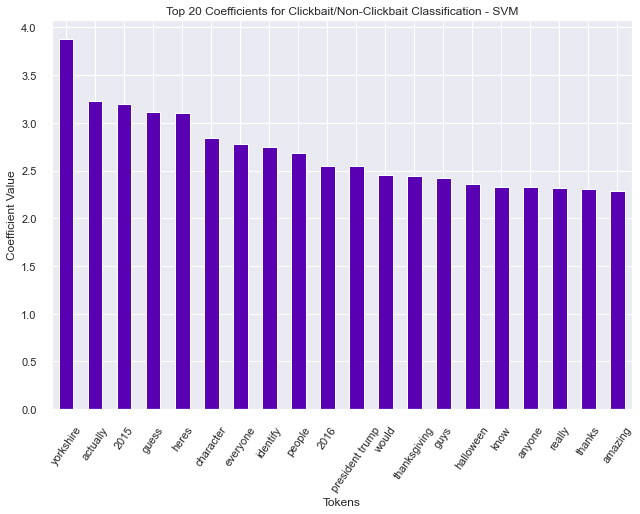

In [89]:
coef_df_svm[0].sort_values(ascending=False).head(20).plot(kind='bar',color='#5900b3')
plt.title("Top 20 Coefficients for Clickbait/Non-Clickbait Classification - SVM")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()

### Logistic Regression

('Training Accuracy:', 0.9998721096787395, ' Training Recall:', 0.9997530986124142)
('Testing Accuracy:', 0.9307910688252896, ' Testing Recall:', 0.923009238891333)


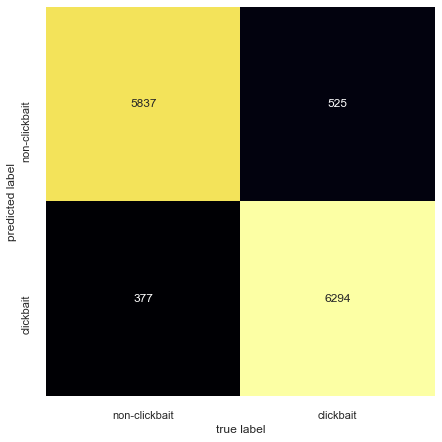

In [90]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=500, class_weight = 'balanced', solver = 'liblinear', tol=0.0001)

lr.fit(X_train,y_train)

lr_train_preds = lr.predict(X_train)
lr_test_preds = lr.predict(X_test)

print(train_results(lr_train_preds))
print(test_results(lr_test_preds))

#confusion matrix on test set lr Classifier 
sns.set()

cm_dc = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

In [91]:
lr.coef_
#svm coefficients
#creating dataframe for SVM coefficients to evaluate the highest coefficients
coef_lr = pd.DataFrame(lr.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_lr=coef_lr.T

In [92]:
all_feat_names_3 = []

In [93]:
for i in engf_name_list:
    all_feat_names_3.append(i)

In [94]:
for i in tfidf.get_feature_names():
    all_feat_names_3.append(i)

In [95]:
coef_df_lr['tokens']=all_feat_names_3

In [96]:
coef_df_lr

,0,tokens
0,1.320182,question
1,6.348483,exclamation
2,4.297075,starts_with_num
3,0.451174,headline_words
4,-0.198657,00
...,...,...
203030,-0.490912,新增病例数攀升引发担忧但美元削弱其避险吸引力
203031,-0.490912,新增病例数攀升引发担忧但美元削弱其避险吸引力 路透
203032,-0.490912,路透
203033,-0.490912,金价持稳


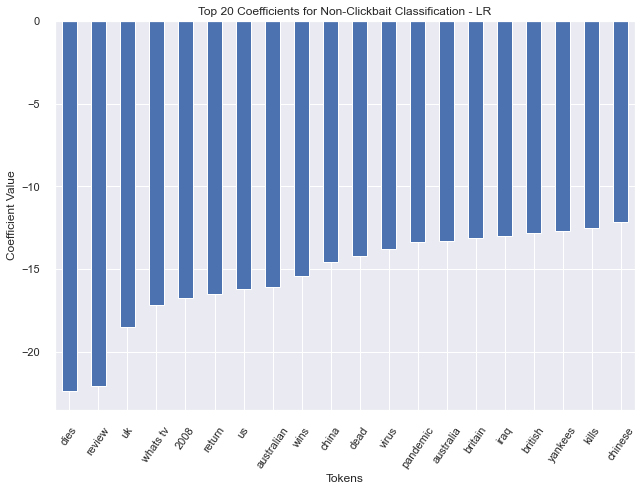

In [97]:
coef_df_lr.set_index('tokens',inplace=True)
coef_df_lr[0].sort_values(ascending=True).head(20).plot(kind='bar')
plt.title("Top 20 Coefficients for Non-Clickbait Classification - LR")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()

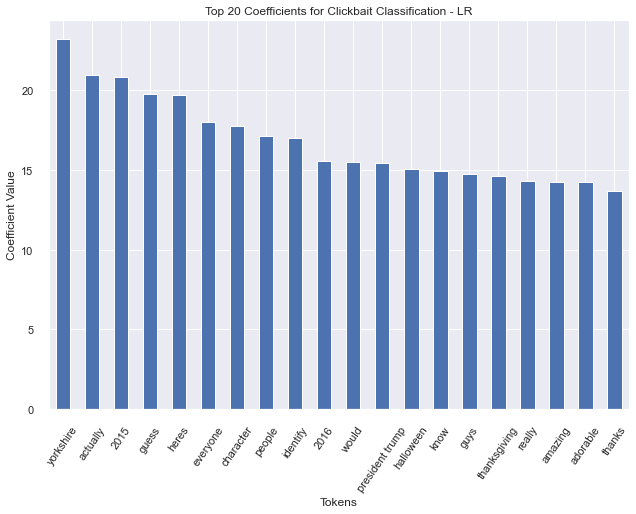

In [98]:
coef_df_lr[0].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title("Top 20 Coefficients for Clickbait Classification - LR")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()